<a href="https://colab.research.google.com/github/Saarss-2211/projects/blob/main/Graph_Aware_DQN_(GNN_%2B_DQN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


MOUNTING

In [14]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pip install -q torch torchvision torchaudio --upgrade
!pip install -q pandas numpy scikit-learn matplotlib seaborn tqdm
print("Installs done.")


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

INSTALLS

In [32]:
!pip install torch-geometric

IMPORTS

In [30]:
import pandas as pd
import torch
import ast
import random
import torch.nn as nn
import torch.nn.functional as F

from itertools import combinations
from collections import defaultdict, deque
from torch_geometric.nn import GATConv


LOAD DATA

In [38]:
pdets = pd.read_csv("pdets.csv", usecols=["problem_id","skills"])
plogs = pd.read_csv("plogs.csv",
    usecols=["student_id","problem_id","correct","attempt_count","fraction_of_hints_used"],
    low_memory=False
)

pdets = pdets.dropna(subset=["skills"])
pdets["skills"] = pdets["skills"].apply(ast.literal_eval)

for c in ["correct","attempt_count","fraction_of_hints_used"]:
    plogs[c] = pd.to_numeric(plogs[c], errors="coerce")

plogs = plogs.dropna(subset=["correct"])
plogs["attempt_count"] = plogs["attempt_count"].fillna(1)
plogs["fraction_of_hints_used"] = plogs["fraction_of_hints_used"].fillna(0.0)


BUILD SKILL GRAPH

In [39]:
edge_counter = defaultdict(int)

for skills in pdets["skills"]:
    if len(skills)>1:
        for a,b in combinations(skills,2):
            edge_counter[(a,b)] +=1
            edge_counter[(b,a)] +=1

all_skills = set(s for skills in pdets["skills"] for s in skills)
skill2id = {s:i for i,s in enumerate(all_skills)}

edges=[]
for (a,b),_ in edge_counter.items():
    edges.append([skill2id[a],skill2id[b]])

edge_index = torch.tensor(edges).t().long()


NODE FEATURES

In [43]:
# ================= NODE FEATURES (ROBUST) =================

# Ensure same dtype for merge
pdets["problem_id"] = pdets["problem_id"].astype(str)
plogs["problem_id"] = plogs["problem_id"].astype(str)

merged = plogs.merge(pdets, on="problem_id", how="inner")

print("Merged rows:", len(merged))

skill_correct = defaultdict(list)

for _, r in merged.iterrows():
    if not isinstance(r["skills"], list):
        continue
    for s in r["skills"]:
        if pd.notna(r["correct"]):
            skill_correct[s].append(float(r["correct"]))

# Build node feature vector (mean correctness per skill)
x_vals = []

for s in skill2id:
    vals = skill_correct.get(s, [])

    if len(vals) == 0:
        x_vals.append(0.0)        # unseen skill
    else:
        x_vals.append(sum(vals)/len(vals))

x = torch.tensor(x_vals, dtype=torch.float32).unsqueeze(1)

print("Node feature shape:", x.shape)


Merged rows: 0
Node feature shape: torch.Size([380, 1])


# GAT MODEL

In [44]:
class SkillGAT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.g1 = GATConv(1,64,heads=4)
        self.g2 = GATConv(256,128,heads=1,concat=False)

    def forward(self,x,e):
        x = F.elu(self.g1(x,e))
        return self.g2(x,e)

gat = SkillGAT()
skill_embeddings = gat(x,edge_index)




In [45]:
gat = SkillGAT()

skill_embeddings = gat(x, edge_index)

print("Skill embedding shape:", skill_embeddings.shape)


Skill embedding shape: torch.Size([380, 128])


# Build Problem → Skill Embedding Map

In [35]:
# --------------------------------
# Map each problem to mean skill embedding
# --------------------------------

problem_skill_emb = {}

for _, row in pdets.iterrows():
    pid = row["problem_id"]
    skill_ids = [skill2id[s] for s in row["skills"] if s in skill2id]

    if len(skill_ids) == 0:
        continue

    emb = skill_embeddings[skill_ids].mean(dim=0)
    problem_skill_emb[pid] = emb.detach()


PROBLEM → EMBEDDING

In [46]:
problem_skill_emb={}

for _,r in pdets.iterrows():
    ids=[skill2id[s] for s in r["skills"]]
    problem_skill_emb[r["problem_id"]] = skill_embeddings[ids].mean(0).detach()


# Build Student Interaction Sequences

In [22]:
student_states = defaultdict(list)

for _,row in plogs_full.iterrows():

    pid = row["problem_id"]
    sid = row["student_id"]

    if pid not in problem_skill_emb:
        continue

    attempts = float(row["attempt_count"])
    hints = float(row["fraction_of_hints_used"])
    correct = float(row["correct"])

    skill_vec = problem_skill_emb[pid]

    meta = torch.tensor([attempts, correct, hints], dtype=torch.float32)

    state = torch.cat([meta, skill_vec])

    student_states[sid].append((state, pid, correct))


# define DQN

In [88]:
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(
            nn.Linear(131,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,TOP_K)
        )
    def forward(self,x):
        return self.net(x)

policy=DQN()
target=DQN()
target.load_state_dict(policy.state_dict())


<All keys matched successfully>

REPLAY BUFFER and action space

In [74]:
# rebuild action space using STRING ids
TOP_K = 200

top_probs = plogs["problem_id"].value_counts().head(TOP_K).index.astype(str).tolist()

action2idx = {p:i for i,p in enumerate(top_probs)}
idx2action = {i:p for p,i in action2idx.items()}

# reset buffer
buf = Buffer()

# repopulate buffer
for sid,seq in student_states.items():
    for i in range(len(seq)-1):
        s,p,r = seq[i]
        s2,_,_ = seq[i+1]

        p = str(p)

        if p in action2idx:
            buf.push(s, action2idx[p], r, s2)

print("Replay buffer size:", len(buf))




Replay buffer size: 50000


In [89]:
buf = Buffer()

for sid,seq in student_states.items():
    for i in range(len(seq)-1):

        s,p,r = seq[i]
        s2,_,_ = seq[i+1]

        p = str(p)

        if p not in action2idx:
            continue

        # Skip NaNs
        if torch.isnan(s).any() or torch.isnan(s2).any():
            continue

        if pd.isna(r):
            continue

        buf.push(s, action2idx[p], float(r), s2)

print("Replay buffer size:", len(buf))


Replay buffer size: 50000


TRAIN

In [90]:
opt = torch.optim.Adam(policy.parameters(), lr=5e-4)
GAMMA = 0.95

for ep in range(20):

    batch = buf.sample(32)

    s,a,r,s2 = zip(*batch)

    s = torch.stack(s)
    s2 = torch.stack(s2)
    a = torch.tensor(a)
    r = torch.tensor(r)

    q = policy(s).gather(1,a.unsqueeze(1)).squeeze()

    with torch.no_grad():
        q2 = target(s2).max(1)[0]

    target_q = r + GAMMA*q2

    # HARD clamp
    q = torch.clamp(q, -10, 10)
    target_q = torch.clamp(target_q, -10, 10)

    loss = nn.MSELoss()(q,target_q)

    opt.zero_grad()
    loss.backward()

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(policy.parameters(), 1.0)

    opt.step()

    if ep%2==0:
        target.load_state_dict(policy.state_dict())

    print("Epoch",ep,"Loss",loss.item())


Epoch 0 Loss 0.8579668998718262
Epoch 1 Loss 0.8371942043304443
Epoch 2 Loss 0.6646444797515869
Epoch 3 Loss 0.8481236696243286
Epoch 4 Loss 0.6920028924942017
Epoch 5 Loss 0.8075976967811584
Epoch 6 Loss 0.7919889092445374
Epoch 7 Loss 0.9443176984786987
Epoch 8 Loss 0.8537812829017639
Epoch 9 Loss 0.9967412948608398
Epoch 10 Loss 0.5821431875228882
Epoch 11 Loss 0.7581338882446289
Epoch 12 Loss 0.7371801733970642
Epoch 13 Loss 0.9248772859573364
Epoch 14 Loss 0.7740581035614014
Epoch 15 Loss 0.7473443150520325
Epoch 16 Loss 0.8739178776741028
Epoch 17 Loss 0.733138382434845
Epoch 18 Loss 0.7374660968780518
Epoch 19 Loss 0.9184627532958984


In [91]:
# Pick one student
sid = list(student_states.keys())[0]

# Take their last state
last_state = student_states[sid][-1][0]

with torch.no_grad():
    qvals = policy(last_state.unsqueeze(0))

best_action = torch.argmax(qvals).item()

recommended_problem = idx2action[best_action]

print("Student ID:", sid)
print("Recommended next problem:", recommended_problem)


Student ID: 558286
Recommended next problem: 1518241


In [92]:
loss_history = []

BATCH = min(32, len(buf))

for ep in range(20):

    if len(buf) < 5:
        print("Buffer too small:", len(buf))
        break

    batch = buf.sample(BATCH)
    s,a,r,s2 = zip(*batch)

    s = torch.stack(s)
    s2 = torch.stack(s2)
    a = torch.tensor(a)
    r = torch.tensor(r)

    q = policy(s).gather(1,a.unsqueeze(1)).squeeze()

    with torch.no_grad():
        q2 = target(s2).max(1)[0]

    target_q = r + 0.99*q2

    loss = nn.MSELoss()(q,target_q)

    opt.zero_grad()
    loss.backward()
    opt.step()

    loss_history.append(loss.item())

    if ep%2==0:
        target.load_state_dict(policy.state_dict())

    print("Epoch",ep,"Loss",loss.item())


Epoch 0 Loss 0.7968778610229492
Epoch 1 Loss 0.9932098388671875
Epoch 2 Loss 0.8523029685020447
Epoch 3 Loss 0.7474620342254639
Epoch 4 Loss 0.9308960437774658
Epoch 5 Loss 0.9140129685401917
Epoch 6 Loss 1.1329594850540161
Epoch 7 Loss 0.9123312830924988
Epoch 8 Loss 0.9080108404159546
Epoch 9 Loss 0.9117375612258911
Epoch 10 Loss 1.0482981204986572
Epoch 11 Loss 1.0234066247940063
Epoch 12 Loss 1.0665401220321655
Epoch 13 Loss 1.1942131519317627
Epoch 14 Loss 1.1100789308547974
Epoch 15 Loss 1.3347636461257935
Epoch 16 Loss 1.0239012241363525
Epoch 17 Loss 1.3870991468429565
Epoch 18 Loss 1.045142412185669
Epoch 19 Loss 1.447666883468628


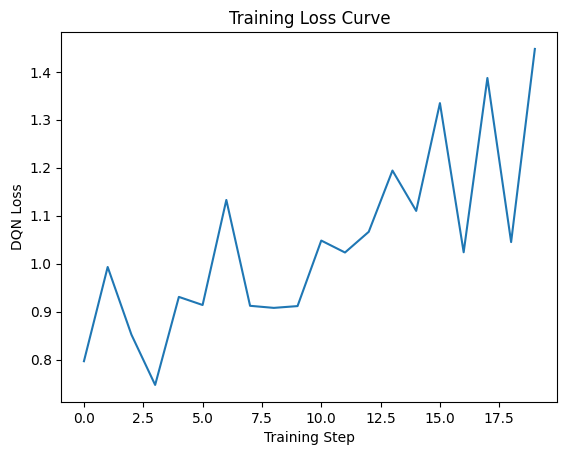

In [93]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss_history)
plt.xlabel("Training Step")
plt.ylabel("DQN Loss")
plt.title("Training Loss Curve")
plt.show()
